In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shared.data import load_imdb
from IPython.display import display_markdown

In [3]:
import en_vectors_web_lg
nlp = en_vectors_web_lg.load()

In [4]:
MAX_WORDS_IN_SENTENCE = 300
LIMIT = -1
dataset_id = 'imdb_{}'.format(LIMIT if LIMIT > 0 else 'all')

In [12]:
from sklearn.model_selection import train_test_split

print("Loading training data...")
X_train, y_train = load_imdb('../data/aclImdb/train', limit=LIMIT)

print("Loading test data...")
# lower text count, because of memory problems when trying to load all
test_limit = LIMIT if 0 <= LIMIT <= 1000 else 1000
X_test, y_test = load_imdb('../data/aclImdb/test', limit=test_limit)

Loading training data...
Loading test data...


In [13]:
import pandas as pd
data = pd.DataFrame({'X': pd.Series(X_train), 'y': pd.Series(y_train[:, 0])})

display_markdown("### Data sample", raw=True)
display(data.head(10))

display_markdown('#### Text stats', raw=True)
display(data.X.describe())

display_markdown('#### Words length stats', raw=True)
display(data.X.apply(lambda w: len(w.split())).describe())

display_markdown('#### Labels stats', raw=True)
display(data.y.describe())

display_markdown('#### Labels counts', raw=True)
display(data.y.value_counts())
display(data.y.value_counts(normalize=True))

display_markdown('### Train count: {}'.format(len(X_train)), raw=True)
display_markdown('### Test count:  {}'.format(len(X_test)), raw=True)

# it's no longer needed, just for presentational purposes
del data

### Data sample

,X,y
0,"b""Dan Katzir has produced a wonderful film tha...",1
1,b'If you want Scream or anything like the big-...,1
2,"b""Outlandish premise that rates low on plausib...",0
3,b'Let\'s face it-- if you rented a STDVD seque...,0
4,b'Bizarre Tobe Hooper exercise regarding an un...,0
5,"b'Well, maybe the PC version of this game was ...",0
6,"b'Watching ""Kroko"" I would have liked to leave...",0
7,"b""First of all, I have to start this comment b...",1
8,"b""Very much a film from the times -- extremely...",0
9,"b'""The Invisible Ray"" is part science fiction ...",1


#### Text stats

count                                                 25000
unique                                                24904
top       b"This show comes up with interesting location...
freq                                                      3
Name: X, dtype: object

#### Words length stats

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: X, dtype: float64

#### Labels stats

count    25000.00000
mean         0.50000
std          0.50001
min          0.00000
25%          0.00000
50%          0.50000
75%          1.00000
max          1.00000
Name: y, dtype: float64

#### Labels counts

1    12500
0    12500
Name: y, dtype: int64

1    0.5
0    0.5
Name: y, dtype: float64

### Train count: 25000

### Test count:  1000

In [7]:
from shared.models import KerasModel
from machine_learning.plot_helpers import plot_training

display_markdown('#### Training or loading model', raw=True)

model = KerasModel(
    nlp, dataset_id, max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=50)

try:
    print("Loading model...")
    model.load()
    print("Model '{}' loaded".format(model.filename))
except IOError:
    print("Unable to load model, training...")
    history = model.train(X_train, y_train)
    model.save()
    print("Model '{}' saved".format(model.filename))
    plot_training(history)

Using TensorFlow backend.


#### Training or loading model

Loading model...
Unable to load model, training...
Epoch 1/50
196/196 [==============================] - 22s 112ms/step - loss: 0.3000 - acc: 0.7361
Epoch 2/50
196/196 [==============================] - 20s 103ms/step - loss: 0.2125 - acc: 0.84251s - loss: 0.2132 - a
Epoch 3/50
196/196 [==============================] - 22s 112ms/step - loss: 0.1832 - acc: 0.8663
Epoch 4/50
196/196 [==============================] - 22s 111ms/step - loss: 0.1615 - acc: 0.8789
Epoch 5/50
196/196 [==============================] - 22s 112ms/step - loss: 0.1445 - acc: 0.8919
Epoch 6/50
196/196 [==============================] - 22s 111ms/step - loss: 0.1319 - acc: 0.8986
Epoch 7/50
196/196 [==============================] - 22s 111ms/step - loss: 0.1241 - acc: 0.9027
Epoch 8/50
196/196 [==============================] - 22s 111ms/step - loss: 0.1163 - acc: 0.9079
Epoch 9/50
196/196 [==============================] - 22s 112ms/step - loss: 0.1106 - acc: 0.9122
Epoch 10/50
196/196 [=========================

In [49]:
display_markdown("#### Overview of created convolutional network architecture", raw=True)

display(model.summary())

#### Overview of created convolutional network architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 296, 32)           48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 64)            10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

None

In [43]:
import numpy as np

from sklearn import pipeline
from shared import transformers

raw_samples = np.array([
    "This movie is, in my opinion, very worth watching!",
    "I kinda liked that movie. Maybe it's not as good as other, but still watchable",
    "I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!",
], dtype='object')

display_markdown("#### Raw text", raw=True)

for text in raw_samples:
    display(text)

display_markdown("#### Cleaned text", raw=True)

clear_pipeline = pipeline.Pipeline([
    ('clear', transformers.ClearTextTransformer()),
])

for text in clear_pipeline.transform(raw_samples):
    display(text)

display_markdown("#### Predicted scores", raw=True)
with pd.option_context("display.max_colwidth", -1):
    display(pd.DataFrame({
        "text": pd.Series(raw_samples),
        "score": pd.Series(model.predict_proba(raw_samples)[:, 1].reshape(len(raw_samples))),
    }))


#### Raw text

'This movie is, in my opinion, very worth watching!'

"I kinda liked that movie. Maybe it's not as good as other, but still watchable"

"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"

#### Cleaned text

'this movie is in my opinion very worth watching!'

"i kinda liked that movie maybe it's not as good as other but still watchable"

"i have to warn everybody this movie is really bad actors don't know how to play it su! !"

#### Predicted scores

,score,text
0,0.957330,"This movie is, in my opinion, very worth watching!"
1,0.718341,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.000038,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


In [23]:
from machine_learning.plot_helpers import plot_confusion_matrix, pandas_settings
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import binarize


# if you want to see whole review, change max_coldwith setting to -1
@pandas_settings(display__max_colwidth=130, display__float_format = '{:.6f}'.format)
def check_model(X_test, y_test, model, show_top_n=5):   
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = binarize(y_pred_proba.reshape(len(y_pred_proba), 1), 0.5)
    
    dt = pd.DataFrame({
        'text': pd.Series(X_test), 
        'prob': pd.Series(y_pred_proba),
        'pred': pd.Series(y_pred.reshape(len(y_pred))),
        'real': pd.Series(y_test.reshape(len(y_test)))
    })
    
    display_markdown("#### Highest {}".format(show_top_n), raw=True)
    display(dt.nlargest(show_top_n, 'prob'))
    
    display_markdown("#### Lowest {}".format(show_top_n), raw=True)
    display(dt.nsmallest(show_top_n, 'prob'))    
    
    display_markdown("#### Highest {} mispredicted".format(show_top_n), raw=True)
    display(dt[dt.pred != dt.real].nlargest(show_top_n, 'prob'))
    
    display_markdown("#### Lowest {} mispredicted".format(show_top_n), raw=True)
    display(dt[dt.pred != dt.real].nsmallest(show_top_n, 'prob'))    
    
    display_markdown("#### Classification report for {}".format(model.NAME), raw=True)
    classes = ['Negative', 'Positive']    
    print(classification_report(y_test, y_pred, target_names=classes))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes)

#### Lowest 5

,pred,prob,real,text
474,0.000000,0.000000,0,"b'As I write this user-comment, Tim Burton\'s interpretation of the Sweeney Todd tale is making big money at the box office an..."
720,0.000000,0.000000,0,"b'To soccer fans every where -- stay away from this movie. It was so baaaaddd! Lame acting, lame script, lame soccer and no di..."
303,0.000000,0.000000,0,"b""I suppose you could say this film has a grain of potential, but nothing more, because boy did the filmmakers botch it. The p..."
44,0.000000,0.000000,0,"b""I just don't know how this stupid, crap, junk, garbage & good for nothing film is a blockbuster. It was so boring with a ver..."
679,0.000000,0.000000,0,"b'""Beowulf"" is like a very bad game : no characters, no story, no real dialogues, bad fights ... It\'s probably the worst movi..."


#### Highest 5

,pred,prob,real,text
101,1.000000,1.000000,1,"b'Up front, if you\'re tired, the first hour could be slow. The set up of the story has a natural leisurely pace, unhurried - ..."
135,1.000000,1.000000,1,"b'As a fan of history, mythology, and fantasy ""Mystic Knights"" show pulled me in from the get-go. It has semi-decent scripting..."
236,1.000000,1.000000,1,"b""This is a truly great film, with excellent direction. The core plot element, the painting of mila's ass is captivating. I re..."
355,1.000000,1.000000,1,"b""Beautiful art direction, excellent editing and wonderful stories make this some of the best television ever produced. The fa..."
427,1.000000,1.000000,1,b'Very glad to see that this excellent film gets such high marks from the users of IMDB. The Best Years of Their Lives remains...


#### Lowest 5 mispredicted

,pred,prob,real,text
549,0.000000,0.000006,1,b'Where do I start. Do I say how great the cinematography is. Do I praise certain scenes which show the directors creativity. ...
821,0.000000,0.000045,1,"b'Sam Firstenberg\'s ""Ninja 3:The Domination"" mixes martial arts with ""The Exorcist"" like horror.The horror elements thrown on..."
341,0.000000,0.000230,1,"b""This is a totally awesome movie! If you haven't seen it yet, you damn well should. Sure, the plot is slow to develop, the sp..."
454,0.000000,0.000389,1,"b""I haven't read the Anne Rice novel that this movie was based on, but who knows, maybe reading the book is cheaper than renti..."
37,0.000000,0.000662,1,b'You have to be awfully patient to sit through a film with one-liners so flat and unfunny that you wonder what all the fuss w...


#### Highest 5 mispredicted

,pred,prob,real,text
523,1.000000,1.000000,0,"b""This film has the language, the style and the attitude down ... plus greats rides from Occy (a world champ) and the great Je..."
71,1.000000,0.999892,0,"b'I went to see this 3 nights ago here in Cork, Ireland. It was the world premiere of it, in the tiny cinema in the Triskel Ar..."
578,1.000000,0.999027,0,b'I think it is very interesting this movie is called a thriller. It is anything but thrilling.<br /><br />Most of the time yo...
182,1.000000,0.998880,0,"b'There must be an error. This movie belongs with ""Plan 9"", and a lot others as a quite entertaining, silly diversion. You\'ll..."
641,1.000000,0.998126,0,b'Another of those flimsy stories coupled with most forgettable musical numbers. Powell and O\'Keefe as battling publicists ar...


#### Classification report for keras

             precision    recall  f1-score   support

   Negative       0.86      0.87      0.86       498
   Positive       0.87      0.85      0.86       502

avg / total       0.86      0.86      0.86      1000



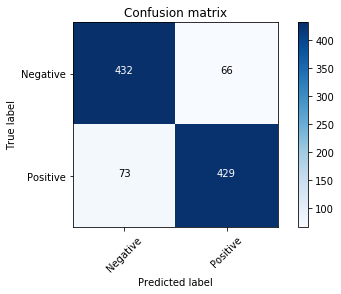

In [24]:
check_model(X_test, y_test, model)